## Portfolio Management - Capital Asset Pricing Model (CAPM)

Portfolio management involves creating and managing a diverse set of assets, such as stocks, bonds, and cash, to align with an investor's long-term financial objectives and risk tolerance. This process involves
* Investment Selection
* Asset Allocation
* Risk Management
* Performance Monitoring

There are different stratergies investors follow to find the optimal allocation of assets that maximizes the return while minimizing the risk. This is done by considering investor's financial goals of return and risk. By **diversifying** the assets across various investment avenues helps achieve an optimal balance of risk and reward.

There are several mathematical models that are used in this optimization problem. In this notebook we use the following model,


**Capital Asset Pricing Model (CAPM)**

This model describes the relationship between systematic risk and expected return for assets, particularly stocks.
It helps in determining the theoretically appropriate required rate of return of an asset, given its risk relative to the market.

The expected return for each asset is given by
$$E(R_i)=R_f+\beta_i(E(R_m)-R_f),$$ where

* $R_i$ return of asset $i$.
* $R_f$ risk free rate
* $\beta_i$ sensitivity of asset price to market risk given by
$$\beta_i=\frac{Cov(R_i, R_m)}{Var(R_m)}$$
* $E(R_m)$ Expected return of market portfolio






In [ ]:
!pip install pypfopt

ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt


In [ ]:
#pip install yfinance

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
#from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting


In [22]:
# input = past n years data
def fetch_past_data(tickers, n):
  # to get previous n years of data
  end_date = datetime.today()
  start_date = end_date - timedelta(days = n*365)
  data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
  return data

In [23]:
# Define tickers and time period
tickers = ['AAPL','MSFT',  'GOOGL', 'AMZN', 'TSLA']
market_ticker = '^GSPC'  # S&P 500 as market index
#start_date = '2018-01-01'
#end_date = '2023-01-01'

# Download data
data = fetch_past_data(tickers+[market_ticker], 5)

returns = data.pct_change().dropna()


[*********************100%***********************]  6 of 6 completed


In [24]:
# Separate stock returns and market returns
asset_returns = returns[tickers]
market_returns = returns[market_ticker]

### Calculate $\beta$ for each asset

In [25]:
# Function to calculate beta using covariance/variance method
def calculate_beta(asset_returns, market_returns):
    betas = {}

    for asset in asset_returns.columns:
        # Covariance of asset returns with market returns
        covariance = np.cov(asset_returns[asset], market_returns)[0][1]

        # Variance of market returns
        market_variance = np.var(market_returns)

        # Beta calculation
        beta = covariance / market_variance
        betas[asset] = beta

    return betas

# Calculate betas for the assets
betas = calculate_beta(asset_returns, market_returns)
print("Betas of Assets:", betas)


Betas of Assets: {'AAPL': 1.1764077551601388, 'MSFT': 1.1760510750806212, 'GOOGL': 1.1327926040291714, 'AMZN': 1.0810472766682153, 'TSLA': 1.5716228382983481}


### Calculate Expected Return Using CAPM

In [26]:
# Calculate the start date (3 months before today)
end_date = datetime.today()
start_date = end_date - timedelta(days=90)  # Approximation of 3 months

# Format dates to strings in 'YYYY-MM-DD' format
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")

# Fetch 3-month Treasury bill data (risk-free rate proxy)
risk_free_data = yf.download("^IRX", start=start_date_str, end=end_date_str)
risk_free_rate = risk_free_data['Close'].mean() / 100
risk_free_rate = risk_free_rate.iloc[-1]
risk_free_rate

[*********************100%***********************]  1 of 1 completed


0.04461793642195445

In [27]:
# Function to calculate expected return using CAPM formula
def calculate_expected_return(betas, risk_free_rate, market_return):
    expected_returns = {}

    for asset, beta in betas.items():
        expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
        expected_returns[asset] = expected_return

    return expected_returns

market_return = market_returns.mean() * 252  # Expected market return (annualized)

# Calculate expected returns for each asset
expected_returns = calculate_expected_return(betas, risk_free_rate, market_return)
print("Expected Returns Using CAPM:", expected_returns)


Expected Returns Using CAPM: {'AAPL': 0.17061315435761995, 'MSFT': 0.17057495333067585, 'GOOGL': 0.16594189947347038, 'AMZN': 0.160399889256861, 'TSLA': 0.21294134397813333}


### Portfolio Optimization (Mean-Variance Optimization)

In [28]:
from scipy.optimize import minimize

# Convert the CAPM expected returns dictionary to a numpy array
capm_expected_returns = np.array(list(expected_returns.values()))

# Function to calculate portfolio performance (return and risk)
def portfolio_performance(weights, returns, cov_matrix):
    # Calculate portfolio return
    portfolio_return = np.sum(weights * returns)

    # Calculate portfolio risk (standard deviation)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_risk = np.sqrt(portfolio_variance)

    return portfolio_return, portfolio_risk

# Define function to minimize (negative Sharpe ratio)
def objective(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_risk = portfolio_performance(weights, returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    return (-1)*sharpe_ratio  # Negative because we want to maximize Sharpe ratio

# Initial guess (equal weight for all assets)
num_assets = len(tickers)
initial_weights = np.ones(num_assets) / num_assets

# Constraints (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds for weights (between 0 and 1 for each asset)
bounds = tuple((0, 1) for asset in range(num_assets))

# Optimize portfolio (maximize Sharpe ratio)
result = minimize(objective, initial_weights, args=(capm_expected_returns, cov_matrix, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimal weights
optimal_weights = result.x

# Calculate the optimized portfolio performance
optimal_return, optimal_risk = portfolio_performance(optimal_weights, capm_expected_returns, cov_matrix)

# Calculate the optimized Sharpe Ratio
max_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_risk

print("Optimal Portfolio Weights:", optimal_weights)
print("Optimal Portfolio Expected Return:", optimal_return)
print("Optimal Portfolio Risk (Standard Deviation):", optimal_risk)
print("Optimal Sharpe Ratio:", max_sharpe_ratio)


Optimal Portfolio Weights: [0.33209341 0.39372946 0.20487069 0.02734839 0.04195804]
Optimal Portfolio Expected Return: 0.17113780189104927
Optimal Portfolio Risk (Standard Deviation): 0.2860592712598925
Optimal Sharpe Ratio: 0.4422854917858899


### Plot portfolio weights

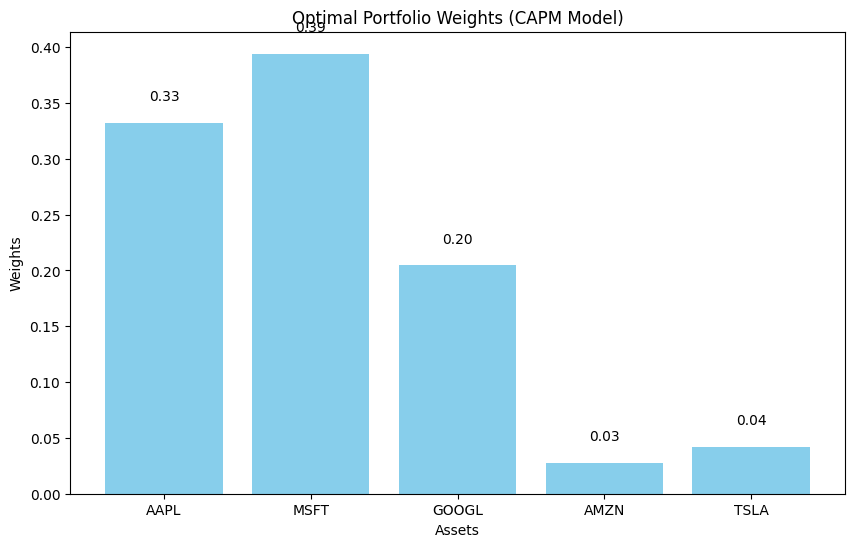

In [17]:
# Plot Portfolio Weights
def plot_weights(weights, tickers, title):
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, weights, color='skyblue')
    plt.xlabel('Assets')
    plt.ylabel('Weights')
    plt.title(title)
    for i, w in enumerate(weights):
        plt.text(i, w + 0.02, f"{w:.2f}", ha='center')
    plt.show()

plot_weights(optimal_weights, tickers, "Optimal Portfolio Weights (CAPM Model)")

### Visualize the efficient frontier

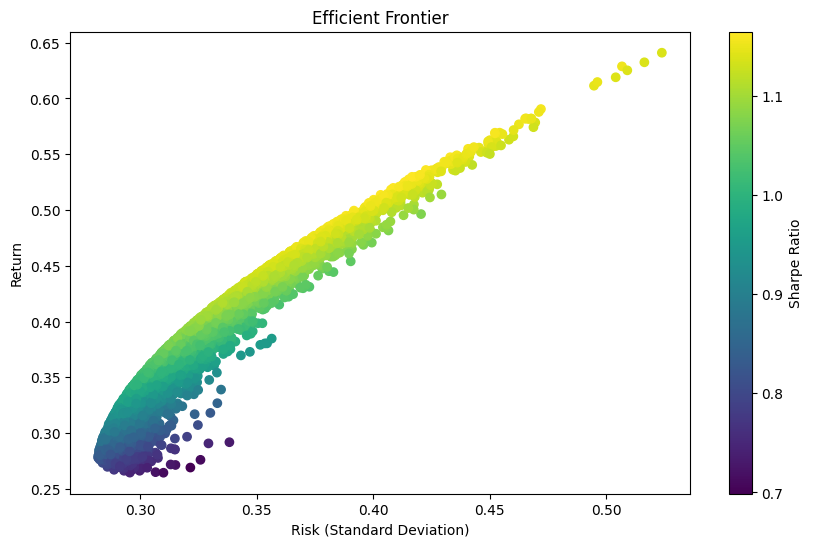

In [18]:
# Function to simulate the efficient frontier
def efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)

        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)

        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_risk  # Sharpe ratio

    return results

# Simulate portfolios and get the efficient frontier
results = efficient_frontier(mean_returns, cov_matrix)

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()
